<a href="https://colab.research.google.com/github/jopiyo/IQHTS/blob/master/CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import keras
import cv2
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
from glob import glob
from keras.models import Model
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing import image
from sklearn.metrics import classification_report
from PIL import Image               # to load images
from IPython.display import display # to display images

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


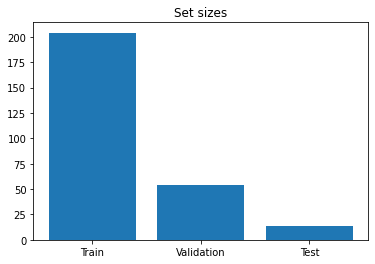

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# load the normalized images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)
vali_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# generate batches of train images and labels
train_generator = train_datagen.flow_from_directory(
        './dataset2/train',
        target_size=(224, 224),
        batch_size=64,
        classes = ['new','old'],
        shuffle = True,
        class_mode='categorical')

# generate batches of validation images and labels
validation_generator = vali_datagen.flow_from_directory(
        './dataset2/val',
        target_size=(224, 224),
        batch_size=64,
        classes = ['new','old'],
        shuffle = True,
        class_mode='categorical')

# generate batches of test images and labels
test_generator = test_datagen.flow_from_directory(
        './dataset2/test',
        target_size=(224, 224),
        batch_size=64,
        classes = ['new','old'],
        shuffle = True,
        class_mode='categorical')

plt.title("Set sizes")
plot_image = [204,54,14]
plt.bar(["Train","Validation","Test"],height=plot_image)
plt.savefig('dataset.png')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy(curr_model_hist, model_name):
    #getting accuracy of each epochs
    plt.plot(curr_model_hist.history['acc'])
    #getting validation accuracy of each epochs
    plt.plot(curr_model_hist.history['val_acc'])
    plt.legend(['train', 'validation'], loc='lower right')
    plt.title('Accuracy plot - train vs validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.savefig(model_name + '_accuracy_graph.png')
    plt.show()

def plot_loss(curr_model_hist, model_name):
    plt.plot(curr_model_hist.history['loss']) #getting  loss of each epochs
    plt.plot(curr_model_hist.history['val_loss']) #getting  validation loss of each epochs
    plt.legend(['training', 'validation'], loc = 'upper right')
    plt.title('Loss plot - train vs vaidation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(model_name + '_loss_graph.png')
    plt.show()

# Initializing Model Architectures 
## Included imagenet weights 

# Training using VGG16

In [ ]:
# import the models for further classification experiments
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
      # init the models with imagenet pretrained weights
    base = VGG16(input_shape=(224,224,3), include_top=False, \
                       pooling='max', weights='imagenet')

      # first: train only the top layers (which were randomly       initialized)
      # i.e. freeze all convolutional layers
    base.trainable = False

    # add a softmax output layer with two outputs
    dense = Dense(2, activation='softmax', name='dense')(base.output)

      # creating the final model, this is the model we will train
    model = Model(inputs=base.inputs, outputs=dense, name='VGG19')
    # configure the model for training
    model.compile(loss='categorical_crossentropy',
          
          metrics=['acc'])
    return model

VGG16 = get_model()

model_name = 'VGG16'
model_file_path = model_name + '.h5'

if os.path.isfile(model_file_path):
      # load weights into new model
      VGG16.load_weights(model_file_path)
      print("Model loaded from disk")
else:
      checkpoint = ModelCheckpoint(model_file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
      reduce_on_plateau = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=5, verbose=1)
      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, baseline=0.1)
      callbacks_list = [checkpoint, reduce_on_plateau, es]
      # use the train and validation feature vectors
      hist = VGG16.fit(train_generator,
            callbacks=callbacks_list,
            epochs=100,
            validation_data=validation_generator,
            verbose=1)

ValueError: ignored

In [ ]:
test_generator.reset()
lossandacc = VGG16.evaluate_generator(test_generator,verbose=1)
#print(lossandacc['acc'])

# get the list of all validation file names
fnames = test_generator.filenames

# get the list of the corresponding classes
ground_truth = test_generator.classes

# get the dictionary of classes
label2index = test_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print("The list of classes: ", idx2label)

# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
test_generator.reset()
prob = VGG16.predict(test_generator)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(prob,axis=1)
errors = np.where(predictions != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),14))

# show a nicely formatted classification report
print(classification_report(test_generator.classes, predictions,
	target_names=test_generator.class_indices.keys()))

if os.path.isfile(model_name + '_accuracy_graph.png'):
    pil_im = Image.open(model_name + '_accuracy_graph.png')
    display(pil_im)
    pil_im = Image.open(model_name + '_loss_graph.png')
    display(pil_im)
else:
    plot_accuracy(hist, model_name)
    plot_loss(hist, model_name)

ValueError: ignored

In [ ]:
test_dir = './dataset/test'

# create figure (fig)
fig=plt.figure(figsize=(12,7))
columns = 4
rows = 1

# ax enables access to manipulate each of subplots
ax = []

for i in range(len(errors)):
    fig.add_subplot(rows, columns, i+1)
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))

    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('Original label: {}, Prediction: {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label))  # set title
    plt.axis('off')
    plt.imshow(original)
plt.savefig(model_name + '_errors.png')
plt.show()

NameError: ignored

<Figure size 864x504 with 0 Axes>

In [ ]:
os.path.exists(test_dir)

False

# Training using InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
    base = InceptionV3(input_shape=(224,224,3), include_top=False, \
                       pooling='max', weights='imagenet')
    base.trainable = False
    dense = Dense(2, activation='softmax', name='dense')(base.output)

    model = Model(inputs=base.inputs, outputs=dense, name='InceptionV3')
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.001),
          metrics=['acc'])
    return model

InceptionV3 = get_model()

model_name = 'InceptionV3'
model_file_path = model_name + '.h5'

if os.path.isfile(model_file_path):
      # load weights into new model
      InceptionV3.load_weights(model_file_path)
      print("Model loaded from disk")
else:
      checkpoint = ModelCheckpoint(model_file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
      reduce_on_plateau = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=5, verbose=1)
      es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=8)
      callbacks_list = [checkpoint, reduce_on_plateau, es]
      hist = InceptionV3.fit(train_generator,
            callbacks=callbacks_list,
            epochs=100,
            validation_data=validation_generator,
            verbose=1)


Model loaded from disk


Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  [&#39;...&#39;]
1/1 [==============================] - 4s 4s/step - loss: 1.2201 - acc: 0.7857
The list of classes:  [&#39;new&#39;, &#39;old&#39;]
[INFO] evaluating network...
Number of errors = 3/14
              precision    recall  f1-score   support

         new       0.00      0.00      0.00         3
         old       0.79      1.00      0.88        11

    accuracy                           0.79        14
   macro avg       0.39      0.50      0.44        14
weighted avg       0.62      0.79      0.69        14



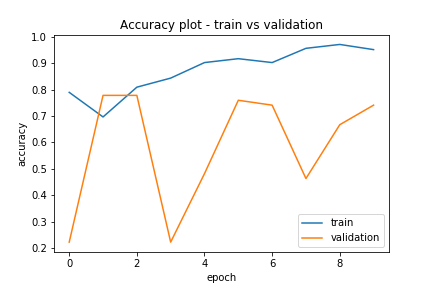

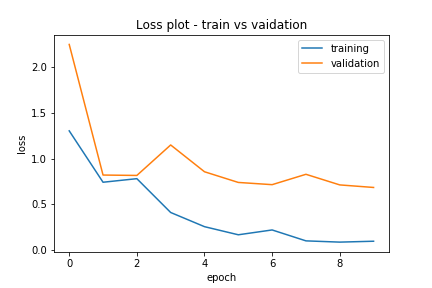

In [ ]:
test_generator.reset()
lossandacc = InceptionV3.evaluate_generator(test_generator,verbose=1)
#print(lossandacc)

# get the list of all validation file names
fnames = test_generator.filenames

# get the list of the corresponding classes
ground_truth = test_generator.classes

# get the dictionary of classes
label2index = test_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print("The list of classes: ", idx2label)

# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
test_generator.reset()
prob = InceptionV3.predict(test_generator)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(prob,axis=1)
errors = np.where(predictions != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),14))

# show a nicely formatted classification report
print(classification_report(test_generator.classes, predictions,
	target_names=test_generator.class_indices.keys()))

if os.path.isfile(model_name + '_accuracy_graph.png'):
    pil_im = Image.open(model_name + '_accuracy_graph.png')
    display(pil_im)
    pil_im = Image.open(model_name + '_loss_graph.png')
    display(pil_im)
else:
    plot_accuracy(hist, model_name)
    plot_loss(hist, model_name)

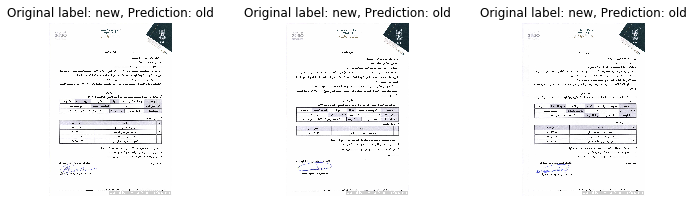

In [ ]:
test_dir = './dataset2/test'

# create figure (fig)
fig=plt.figure(figsize=(12,7))
columns = 3
rows = 2

# ax enables access to manipulate each of subplots
ax = []

for i in range(len(errors)):
    fig.add_subplot(rows, columns, i+1)
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))

    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('Original label: {}, Prediction: {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label))  # set title
    plt.axis('off')
    plt.imshow(original)
plt.savefig(model_name + '_errors.png')
plt.show()

# Training using ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
    base = ResNet50(input_shape=(224,224,3), include_top=False, \
                       pooling='max', weights='imagenet')
    base.trainable = False
    dense = Dense(2, activation='softmax', name='dense')(base.output)

    model = Model(inputs=base.inputs, outputs=dense, name='ResNet50')
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.001),
          metrics=['acc'])
    return model

ResNet50 = get_model()

model_name = 'ResNet50'
model_file_path = model_name + '.h5'

if os.path.isfile(model_file_path):
      # load weights into new model
      ResNet50.load_weights(model_file_path)
      print("Model loaded from disk")
else:
      checkpoint = ModelCheckpoint(model_file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
      reduce_on_plateau = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=5, verbose=1)
      es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=8)
      callbacks_list = [checkpoint, reduce_on_plateau, es]
      hist = ResNet50.fit(train_generator,
            callbacks=callbacks_list,
            epochs=100,
            validation_data=validation_generator,
            verbose=1)

Model loaded from disk


Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  [&#39;...&#39;]
1/1 [==============================] - 3s 3s/step - loss: 0.7831 - acc: 0.7857
The list of classes:  [&#39;new&#39;, &#39;old&#39;]
[INFO] evaluating network...
Number of errors = 3/14
              precision    recall  f1-score   support

         new       0.00      0.00      0.00         3
         old       0.79      1.00      0.88        11

    accuracy                           0.79        14
   macro avg       0.39      0.50      0.44        14
weighted avg       0.62      0.79      0.69        14



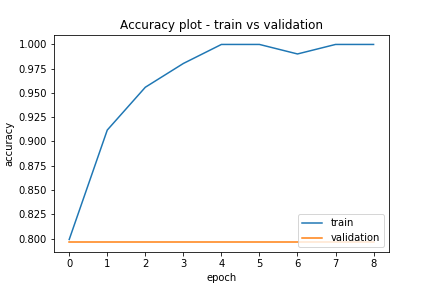

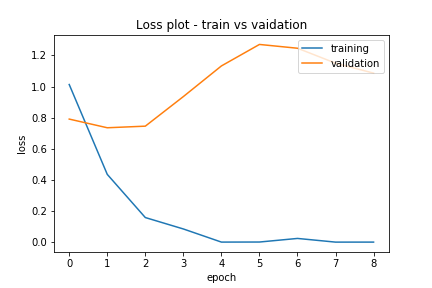

In [ ]:
test_generator.reset()
lossandacc = ResNet50.evaluate_generator(test_generator,verbose=1)
#print(lossandacc['acc'])

# get the list of all validation file names
fnames = test_generator.filenames

# get the list of the corresponding classes
ground_truth = test_generator.classes

# get the dictionary of classes
label2index = test_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print("The list of classes: ", idx2label)

# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
test_generator.reset()
prob = ResNet50.predict(test_generator)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(prob,axis=1)
errors = np.where(predictions != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),14))

# show a nicely formatted classification report
print(classification_report(test_generator.classes, predictions,
	target_names=test_generator.class_indices.keys()))

if os.path.isfile(model_name + '_accuracy_graph.png'):
    pil_im = Image.open(model_name + '_accuracy_graph.png')
    display(pil_im)
    pil_im = Image.open(model_name + '_loss_graph.png')
    display(pil_im)
else:
    plot_accuracy(hist, model_name)
    plot_loss(hist, model_name)


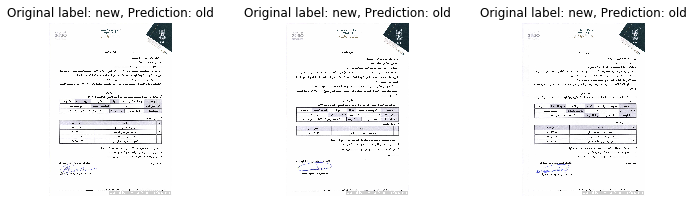

In [ ]:
test_dir = './dataset2/test'

# create figure (fig)
fig=plt.figure(figsize=(12,7))
columns = 3
rows = 2

# ax enables access to manipulate each of subplots
ax = []

for i in range(len(errors)):
    fig.add_subplot(rows, columns, i+1)
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))

    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('Original label: {}, Prediction: {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label))  # set title
    plt.axis('off')
    plt.imshow(original)
plt.savefig(model_name + '_errors.png')
plt.show()

# Training using InceptionResNetV2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
    base = InceptionResNetV2(input_shape=(224,224,3), include_top=False, \
                       pooling='max', weights='imagenet')
    base.trainable = False
    dense = Dense(2, activation='softmax', name='dense')(base.output)

    model = Model(inputs=base.inputs, outputs=dense, name='InceptionResNetV2')
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.001),
          metrics=['acc'])
    return model

InceptionResNetV2 = get_model()

model_name = 'InceptionResNetV2'
model_file_path = model_name + '.h5'

if os.path.isfile(model_file_path):
      # load weights into new model
      InceptionResNetV2.load_weights(model_file_path)
      print("Model loaded from disk")
else:
      checkpoint = ModelCheckpoint(model_file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
      reduce_on_plateau = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=5, verbose=1)
      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, baseline=0.1)
      callbacks_list = [checkpoint, reduce_on_plateau, es]
      hist = InceptionResNetV2.fit(train_generator,
            callbacks=callbacks_list,
            epochs=100,
            validation_data=validation_generator,
            verbose=1)


Model loaded from disk


Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  [&#39;...&#39;]
1/1 [==============================] - 5s 5s/step - loss: 0.4081 - acc: 0.8571
The list of classes:  [&#39;new&#39;, &#39;old&#39;]
[INFO] evaluating network...
Number of errors = 6/14
              precision    recall  f1-score   support

         new       0.00      0.00      0.00         3
         old       0.73      0.73      0.73        11

    accuracy                           0.57        14
   macro avg       0.36      0.36      0.36        14
weighted avg       0.57      0.57      0.57        14



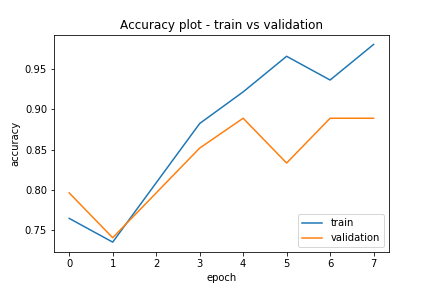

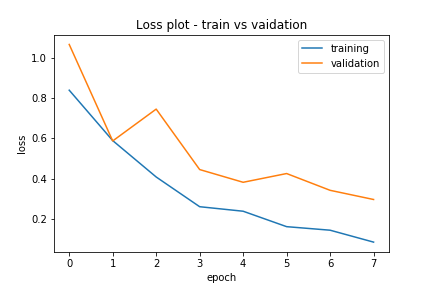

In [ ]:
test_generator.reset()
lossandacc = InceptionResNetV2.evaluate_generator(test_generator,verbose=1)
#print(lossandacc['acc'])

# get the list of all validation file names
fnames = test_generator.filenames

# get the list of the corresponding classes
ground_truth = test_generator.classes

# get the dictionary of classes
label2index = test_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print("The list of classes: ", idx2label)

# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
test_generator.reset()
prob = InceptionResNetV2.predict(test_generator)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(prob,axis=1)
errors = np.where(predictions != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),14))

# show a nicely formatted classification report
print(classification_report(test_generator.classes, predictions,
	target_names=test_generator.class_indices.keys()))

if os.path.isfile(model_name + '_accuracy_graph.png'):
    pil_im = Image.open(model_name + '_accuracy_graph.png')
    display(pil_im)
    pil_im = Image.open(model_name + '_loss_graph.png')
    display(pil_im)
else:
    plot_accuracy(hist, model_name)
    plot_loss(hist, model_name)


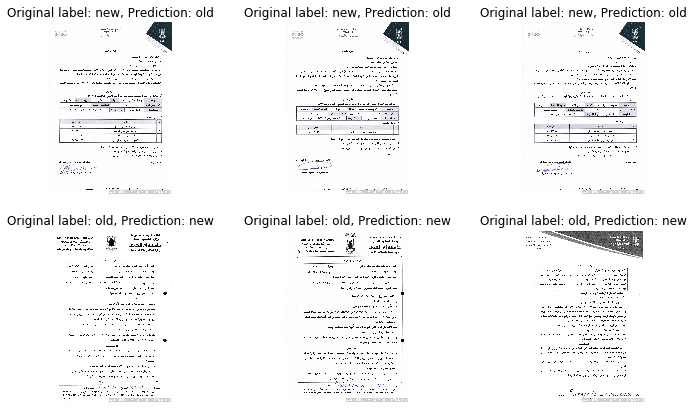

In [ ]:
test_dir = './dataset2/test'

# create figure (fig)
fig=plt.figure(figsize=(12,7))
columns = 3
rows = 2

# ax enables access to manipulate each of subplots
ax = []

for i in range(len(errors)):
    fig.add_subplot(rows, columns, i+1)
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))

    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('Original label: {}, Prediction: {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label))  # set title
    plt.axis('off')
    plt.imshow(original)
plt.savefig(model_name + '_errors.png')
plt.show()

# Training using MobileNetV2

In [ ]:
# import the models for further classification experiments
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
      # init the models with imagenet pretrained weights
    base = MobileNetV2(input_shape=(224,224,3), include_top=False, \
                       pooling='max', weights='imagenet')

      # first: train only the top layers (which were randomly       initialized)
      # i.e. freeze all convolutional layers
    base.trainable = False
    # add a softmax output layer with two outputs
    dense = Dense(2, activation='softmax', name='dense')(base.output)
    
      # creating the final model, this is the model we will train
    model = Model(inputs=base.inputs, outputs=dense, name='mobilenetv2')
    # configure the model for training
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.001),
          metrics=['acc'])
    return model

MobileNetV2 = get_model()

model_name = 'MobileNetV2'
model_file_path = model_name + '.h5'

if os.path.isfile(model_file_path):
      # load weights into new model
      MobileNetV2.load_weights(model_file_path)
      print("Model loaded from disk")
else:
      checkpoint = ModelCheckpoint(model_file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
      reduce_on_plateau = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=5, verbose=1)
      es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=8)
      callbacks_list = [checkpoint, reduce_on_plateau, es]

      # use the train and validation feature vectors
      hist = MobileNetV2.fit(train_generator,
            callbacks=callbacks_list,
            epochs=100,
            validation_data=validation_generator,
            verbose=1)

Model loaded from disk


Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  [&#39;...&#39;]
1/1 [==============================] - 2s 2s/step - loss: 0.6932 - acc: 0.7857
The list of classes:  [&#39;new&#39;, &#39;old&#39;]
[INFO] evaluating network...
Number of errors = 3/14
              precision    recall  f1-score   support

         new       0.00      0.00      0.00         3
         old       0.79      1.00      0.88        11

    accuracy                           0.79        14
   macro avg       0.39      0.50      0.44        14
weighted avg       0.62      0.79      0.69        14



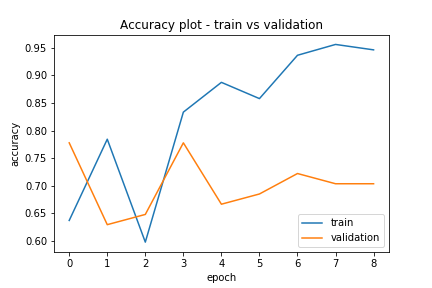

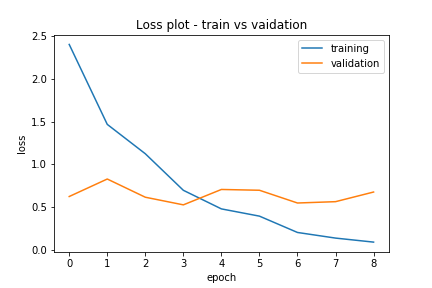

In [ ]:
test_generator.reset()
lossandacc = MobileNetV2.evaluate_generator(test_generator,verbose=1)
#print(lossandacc['acc'])

# get the list of all validation file names
fnames = test_generator.filenames

# get the list of the corresponding classes
ground_truth = test_generator.classes

# get the dictionary of classes
label2index = test_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print("The list of classes: ", idx2label)

# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
test_generator.reset()
prob = MobileNetV2.predict(test_generator)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(prob,axis=1)
errors = np.where(predictions != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),14))

# show a nicely formatted classification report
print(classification_report(test_generator.classes, predictions,
	target_names=test_generator.class_indices.keys()))

if os.path.isfile(model_name + '_accuracy_graph.png'):
    pil_im = Image.open(model_name + '_accuracy_graph.png')
    display(pil_im)
    pil_im = Image.open(model_name + '_loss_graph.png')
    display(pil_im)
else:
    plot_accuracy(hist, model_name)
    plot_loss(hist, model_name)


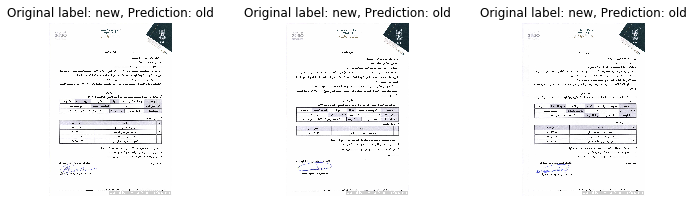

In [ ]:
test_dir = './dataset2/test'

# create figure (fig)
fig=plt.figure(figsize=(12,7))
columns = 3
rows = 2

# ax enables access to manipulate each of subplots
ax = []

for i in range(len(errors)):
    fig.add_subplot(rows, columns, i+1)
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))

    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('Original label: {}, Prediction: {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label))  # set title
    plt.axis('off')
    plt.imshow(original)
plt.savefig(model_name + '_errors.png')
plt.show()

# Training using DenseNet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
    base = DenseNet121(input_shape=(224,224,3), include_top=False, \
                       pooling='max', weights='imagenet')
    base.trainable = False
    dense = Dense(2, activation='softmax', name='dense')(base.output)

    model = Model(inputs=base.inputs, outputs=dense, name='DenseNet121')
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.001),
          metrics=['acc'])
    return model

DenseNet121 = get_model()

model_name = 'DenseNet121'
model_file_path = model_name + '.h5'

if os.path.isfile(model_file_path):
      # load weights into new model
      DenseNet121.load_weights(model_file_path)
      print("Model loaded from disk")
else:
      checkpoint = ModelCheckpoint(model_file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
      reduce_on_plateau = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=5, verbose=1)
      es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=8)
      callbacks_list = [checkpoint, reduce_on_plateau, es]
      hist = DenseNet121.fit(train_generator,
            callbacks=callbacks_list,
            epochs=100,
            validation_data=validation_generator,
            verbose=1)


Model loaded from disk


Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  [&#39;...&#39;]
1/1 [==============================] - 4s 4s/step - loss: 1.1124 - acc: 0.7857
The list of classes:  [&#39;new&#39;, &#39;old&#39;]
[INFO] evaluating network...
Number of errors = 3/14
              precision    recall  f1-score   support

         new       0.00      0.00      0.00         3
         old       0.79      1.00      0.88        11

    accuracy                           0.79        14
   macro avg       0.39      0.50      0.44        14
weighted avg       0.62      0.79      0.69        14



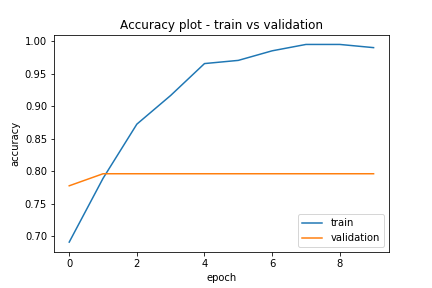

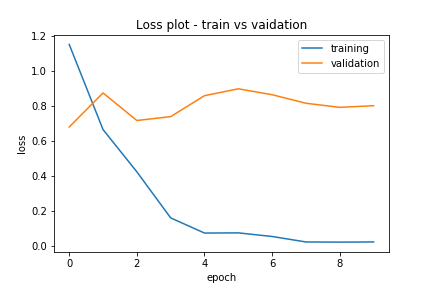

In [ ]:
test_generator.reset()
lossandacc = DenseNet121.evaluate_generator(test_generator,verbose=1)
#print(lossandacc['acc'])

# get the list of all validation file names
fnames = test_generator.filenames

# get the list of the corresponding classes
ground_truth = test_generator.classes

# get the dictionary of classes
label2index = test_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print("The list of classes: ", idx2label)

# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
test_generator.reset()
prob = DenseNet121.predict(test_generator)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(prob,axis=1)
errors = np.where(predictions != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),14))

# show a nicely formatted classification report
print(classification_report(test_generator.classes, predictions,
	target_names=test_generator.class_indices.keys()))

if os.path.isfile(model_name + '_accuracy_graph.png'):
    pil_im = Image.open(model_name + '_accuracy_graph.png')
    display(pil_im)
    pil_im = Image.open(model_name + '_loss_graph.png')
    display(pil_im)
else:
    plot_accuracy(hist, model_name)
    plot_loss(hist, model_name)


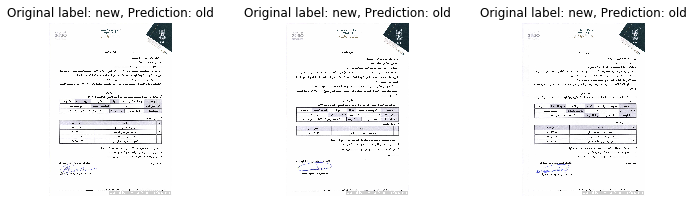

In [ ]:
test_dir = './dataset2/test'

# create figure (fig)
fig=plt.figure(figsize=(12,7))
columns = 3
rows = 2

# ax enables access to manipulate each of subplots
ax = []

for i in range(len(errors)):
    fig.add_subplot(rows, columns, i+1)
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))

    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('Original label: {}, Prediction: {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label))  # set title
    plt.axis('off')
    plt.imshow(original)
plt.savefig(model_name + '_errors.png')
plt.show()

# Training using Xception

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
    base = Xception(input_shape=(224,224,3), include_top=False, \
                       pooling='max', weights='imagenet')
    base.trainable = False
    dense = Dense(2, activation='softmax', name='dense')(base.output)

    model = Model(inputs=base.inputs, outputs=dense, name='Xception')
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.001),
          metrics=['acc'])
    return model

Xception = get_model()

model_name = 'Xception'
model_file_path = model_name + '.h5'

if os.path.isfile(model_file_path):
      # load weights into new model
      Xception.load_weights(model_file_path)
      print("Model loaded from disk")
else:
      checkpoint = ModelCheckpoint(model_file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
      reduce_on_plateau = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=5, verbose=1)
      es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=8)
      callbacks_list = [checkpoint, reduce_on_plateau, es]
      hist = Xception.fit(train_generator,
            callbacks=callbacks_list,
            epochs=100,
            validation_data=validation_generator,
            verbose=1)


Model loaded from disk


Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  [&#39;...&#39;]
1/1 [==============================] - 3s 3s/step - loss: 0.3840 - acc: 0.9286
The list of classes:  [&#39;new&#39;, &#39;old&#39;]
[INFO] evaluating network...
Number of errors = 5/14
              precision    recall  f1-score   support

         new       0.25      0.33      0.29         3
         old       0.80      0.73      0.76        11

    accuracy                           0.64        14
   macro avg       0.53      0.53      0.52        14
weighted avg       0.68      0.64      0.66        14



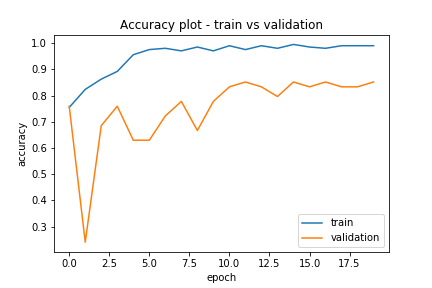

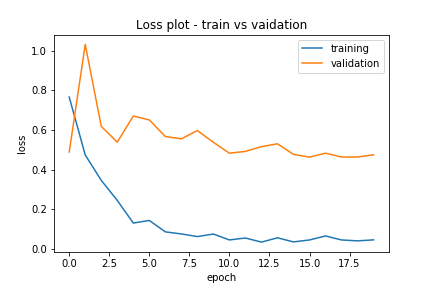

In [ ]:
test_generator.reset()
lossandacc = Xception.evaluate_generator(test_generator,verbose=1)
#print(lossandacc['acc'])

# get the list of all validation file names
fnames = test_generator.filenames

# get the list of the corresponding classes
ground_truth = test_generator.classes

# get the dictionary of classes
label2index = test_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print("The list of classes: ", idx2label)

# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
test_generator.reset()
prob = Xception.predict(test_generator)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(prob,axis=1)
errors = np.where(predictions != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),14))

# show a nicely formatted classification report
print(classification_report(test_generator.classes, predictions,
	target_names=test_generator.class_indices.keys()))

if os.path.isfile(model_name + '_accuracy_graph.png'):
    pil_im = Image.open(model_name + '_accuracy_graph.png')
    display(pil_im)
    pil_im = Image.open(model_name + '_loss_graph.png')
    display(pil_im)
else:
    plot_accuracy(hist, model_name)
    plot_loss(hist, model_name)

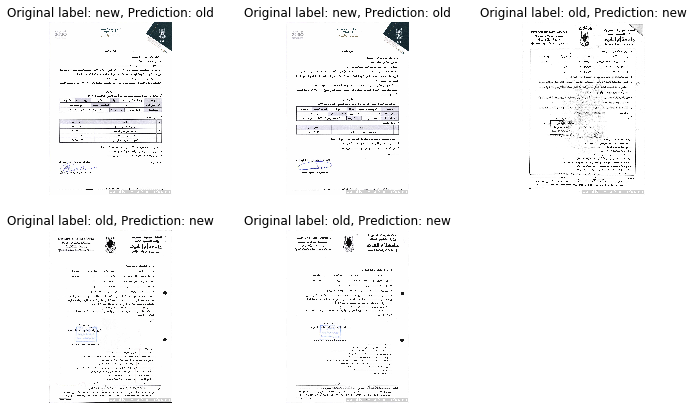

In [ ]:
test_dir = './dataset2/test'

# create figure (fig)
fig=plt.figure(figsize=(12,7))
columns = 3
rows = 2

# ax enables access to manipulate each of subplots
ax = []

for i in range(len(errors)):
    fig.add_subplot(rows, columns, i+1)
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))

    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('Original label: {}, Prediction: {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label))  # set title
    plt.axis('off')
    plt.imshow(original)
plt.savefig(model_name + '_errors.png')
plt.show()